In [114]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import itertools

In [115]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [116]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [117]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data.dropna(inplace=True)

    result = data
    # print(result.head(10))
    return result

In [118]:
def prepare_data(df, target_column, n_steps):

    df = modify_data(df)

    # print(df.head(10))

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    # print(features.head(10))
    features = features.drop(columns = ['Date'])

    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False)

    return X_train, X_test, y_train, y_test

In [119]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [120]:
def build_model(input_shape, md_prm: dict):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return model

In [121]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

In [122]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [123]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=4):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [124]:
# n_steps_options = [5, 10, 15, 20, 25, 30]
# batch_size_options = [32, 64, 128, 256]
# epochs_options = [100, 200, 300, 400]
# rnn_units_options = [50, 100, 150, 200]
n_steps_options = [5,6,7]
batch_size_options = [16,32,64]
epochs_options = [100]
rnn_units_options = [100]

# activation_options = ['relu', 'tanh']
# dropout_options = [0.1, 0.2, 0.3, 0.4]
activation_options = ['tanh']
dropout_options = [0.1, 0.2]

model_params_combinations = list(itertools.product(
    n_steps_options, 
    rnn_units_options, 
    activation_options, 
    dropout_options,
    batch_size_options,
    epochs_options
))
target_column = 'LMCADY_acu_5d_log'

In [125]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 18


In [126]:
def run_model_iterations():
    top_results = []
    i = 1
    for n_steps, rnn_units, activation, dropout, batch_size, epochs in model_params_combinations:
        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}".format(n_steps, rnn_units, activation, dropout))

            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)

            model_params = {
                'n_steps': n_steps,
                'rnn_units': rnn_units,
                'activation': activation,
                'dropout': dropout
            }

            model = build_model((X_train.shape[1], X_train.shape[2]), model_params)
            print(model.summary())
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_test)
            rmse_score = math.sqrt(mean_squared_error(y_test, y_pred))
            std_dev = np.std(y_test)

            diff = rmse_score - std_dev

            result = {
                'n_steps': n_steps,
                'rnn_units': rnn_units,
                'activation': activation,
                'dropout': dropout,
                'batch_size': batch_size,
                'epochs': epochs,
                'rmse': rmse_score,
                'std_dev': std_dev,
                'diff': diff,
                'predictions': y_pred,
                'true_values': y_test
            }

            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['diff'])[:5]

            print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
            print("Params: ", model_params)
            print("Iteration {}/{} completed".format(i, n_iterations))

        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i+=1

    return top_results

In [127]:
top_3_results = run_model_iterations()


Iteration 1/18
n_steps: 4, rnn_units: 100, activation: tanh, dropout: 0.1
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
An error occurred: 4. Skipping this combination.

Iteration 2/18
n_steps: 4, rnn_units: 100, activation: tanh, dropout: 0.1
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
An error occurred: 4. Skipping this combination.

Iteration 3/18
n_steps: 4, rnn_units: 100, activation: tanh, dropout: 0.1
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
An error occurred: 4. Skipping this combination.

Iteration 4/18
n_steps: 4, rnn_units: 100, activation: tanh, dropout: 0.2
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
An error occurred

In [128]:
top_3_results = sorted(top_3_results, key=lambda x: x['diff'])[:5]

Top 1 
RMSE: 0.015359, STD_DEV: 0.030739, DIFF: -0.015380
n_steps: 5, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 16, epochs: 100


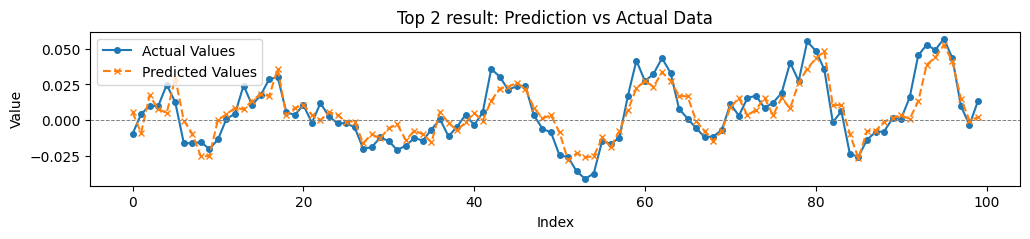

Top 2 
RMSE: 0.015561, STD_DEV: 0.030739, DIFF: -0.015178
n_steps: 6, rnn_units: 100, activation: tanh, dropout: 0.1, batch_size: 16, epochs: 100


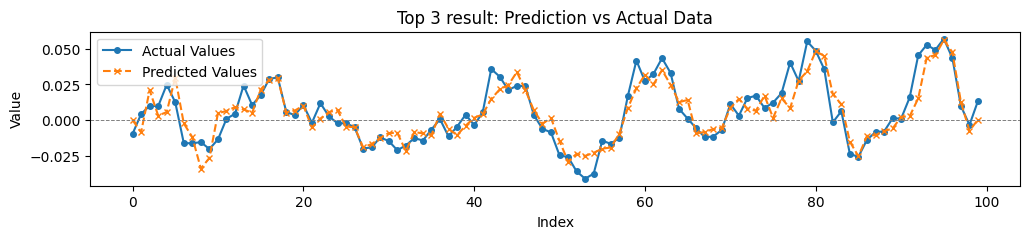

Top 3 
RMSE: 0.015899, STD_DEV: 0.030739, DIFF: -0.014841
n_steps: 6, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 32, epochs: 100


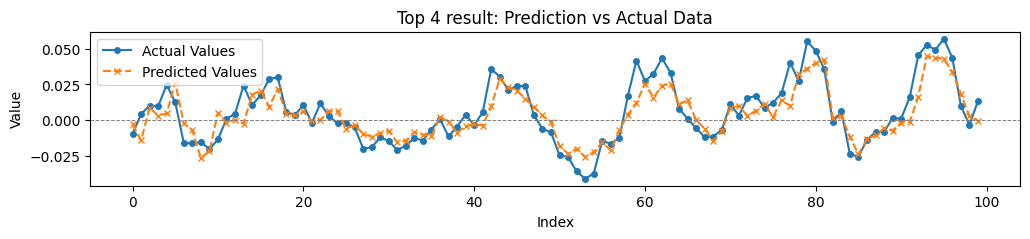

Top 4 
RMSE: 0.016151, STD_DEV: 0.030739, DIFF: -0.014588
n_steps: 6, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 16, epochs: 100


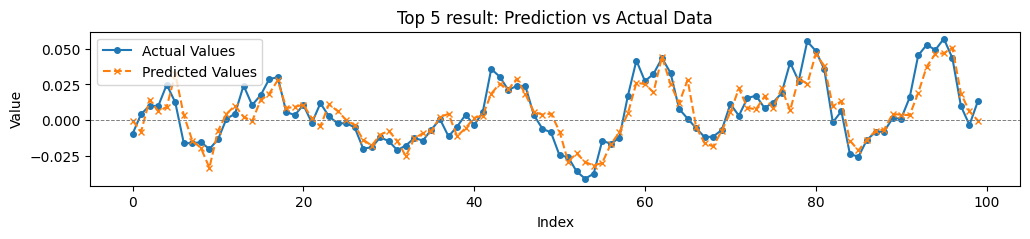

Top 5 
RMSE: 0.016386, STD_DEV: 0.030739, DIFF: -0.014353
n_steps: 5, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 32, epochs: 100


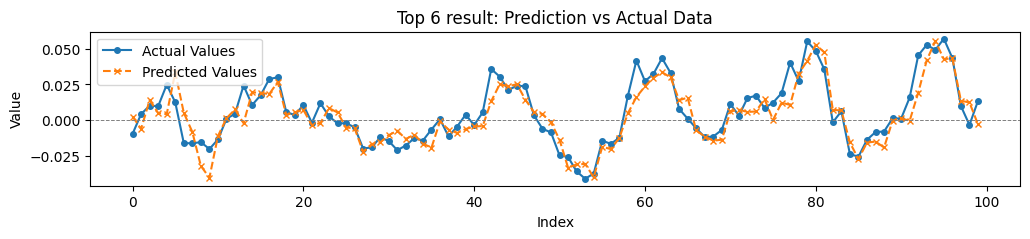

In [129]:
for i,result in enumerate(top_3_results,1):
    print(f"Top {i} ")
    print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(result['rmse'], result['std_dev'], result['diff']))
    print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['rnn_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    plot_predictions(result['true_values'], result['predictions'], 100, title=f"Top {i+1} result: Prediction vs Actual Data")